# Set-Up and Imports

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import surrojax_gp
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
import itertools
import json
import time
from arraytainers import Arraytainer
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

In [2]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100
# Plot theme:
sns.set_theme(style='darkgrid')
palette = sns.color_palette()

In [3]:
ape_ylims = (-1.6, -0.6)

In [4]:
fig_save_dir = './figs/linear_beam'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)
data_save_dir = './data/linear_beam'
if not os.path.isdir(data_save_dir):
    os.makedirs(data_save_dir)

In [5]:
jax_rng = jax.random.PRNGKey(42)
np_seed = 42

# Train Surrogate

In [6]:
def load_beam_data(file_dir):
    with open(file_dir, 'r') as f:
        data = json.load(f)
    C_1 = jnp.array(data['C_1'])
    angles = jnp.array(data['beam_angle'])
    disp = jnp.array(data['end_disp'])
    x = jnp.stack([C_1, angles], axis=-1)
    y = disp.reshape(-1,1)
    C1_pts = jnp.unique(C_1.flatten())
    angle_pts = jnp.unique(angles.flatten())
    C1_grid, angle_grid = np.meshgrid(C1_pts, angle_pts)
    return {'C_1': C1_grid, 'beam_angle': angle_grid, 'end_disp': disp, 'x': x, 'y': y, 'time': jnp.array(data['t_solve'])}

train_data = load_beam_data('../beam/data/linear_beam_training_data.json')

In [7]:
def get_scale_vals(train_data, key):
    if key == 'x':
        min_val = np.min(train_data[key], axis=0)
        max_val = np.max(train_data[key], axis=0)
    else:
        min_val = np.min(train_data[key])
        max_val = np.max(train_data[key])
    return min_val, max_val

disp_min, disp_max = get_scale_vals(train_data, 'end_disp')
print(f'Displacement: min = {disp_min} mm, max = {disp_max} mm')
C1_min, C1_max = get_scale_vals(train_data, 'C_1')
print(f'C_1: min = {C1_min} kPa, max = {C1_max} kPa')
angle_min, angle_max = get_scale_vals(train_data, 'beam_angle')
print(f'Beam angle: min = {angle_min} degrees, max = {angle_max} degrees')

Displacement: min = 0.8523630499839783 mm, max = 58.94761276245117 mm
C_1: min = 1.899999976158142 kPa, max = 6.900000095367432 kPa
Beam angle: min = 0.0 degrees, max = 180.0 degrees


In [8]:
def scale_data(train_data):
    for key in train_data.keys():
        # Don't scale solution time
        if key != 'time':
            min_val, max_val = get_scale_vals(train_data, key)
            train_data[key] = (train_data[key]-min_val)/(max_val-min_val)
    return train_data
train_data = scale_data(train_data)

In [9]:
# Squared Exponential kernel:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)
constraints = {"length_0": {">": 0.01, "<": 1}, 
               "length_1": {">": 0.01, "<": 1}, 
               "const": {">": 0.01, "<": 1}}
print('Training GP...')
np.random.seed(42)
time_0 = time.time()
beam_gp = surrojax_gp.create_gp(kernel, train_data['x'], train_data['y'], constraints)
t_train = time.time() - time_0
print(f'Took {t_train:.2f} seconds to train GP surrogate.')

Training GP...
1175.0901
53.35005
-104.31425
-382.39355
-378.81973
-373.04483
-384.98245
-380.18436
-382.76654
-384.98245
-384.98245
-384.98245
-384.98245
-384.98245
-384.98245
-384.98245
-384.98245
-384.98245
-384.98245
-384.98245
-384.98245
-384.98245
      fun: -384.9824523925781
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.94210434, 39.92941284, 53.80551147])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 22
      nit: 3
     njev: 22
   status: 0
  success: True
        x: array([0.85914133, 0.22394716, 0.17482367])
-381.12225
28322.723
-335.62204
-380.6247
-379.6298
-383.1029
-380.85684
-381.80145
-382.63678
-382.50696
-381.68546
-383.1029
-383.1029
-383.1029
-383.1029
-383.1029
-383.1029
-383.1029
-383.1029
-383.1029
-383.1029
-383.1029
-383.1029
      fun: -383.1029052734375
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([   8.09343338, -125.50004578,  -82.48995972])
  message: 'CONVERGENCE: REL_

In [10]:
surrojax_gp.save_gp(beam_gp, "linear_beam_gp")

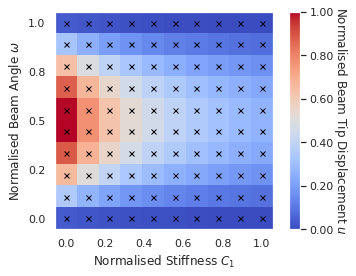

In [11]:
gp_pred = beam_gp.predict(train_data['x'])['mean']
fig = plotting_helpers.plot_gp_heatmap(train_data['C_1'], train_data['beam_angle'], gp_pred, raw_data=train_data, 
                                        z_label='Normalised Beam Tip Displacement $u$', z_lims=(0,1))
# plt.savefig(os.path.join(fig_save_dir, 'gp_pred_training.svg'))
plt.gca().grid(False)
plt.tight_layout()
fig.show()

10000 predictions took 1.17261 seconds to compute (0.00011726090908050537 seconds/simulation)


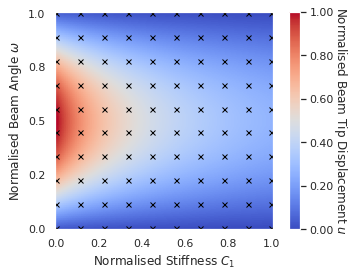

In [12]:
num_pts = 100
C1_grid, angle_grid = plotting_helpers.create_2d_point_grid(C1_lims=(0,1), angle_lims=(0,1), 
                                                            num_C1_pts=num_pts, num_angle_pts=num_pts)
x = plotting_helpers.flatten_and_stack_grids(C1_grid, angle_grid)
time_0 = time.time()
gp_pred = beam_gp.predict(x)['mean']
time_pred = time.time() - time_0
sec_per_pred = time_pred/num_pts**2
print(f'{num_pts**2} predictions took {time_pred:.5f} seconds to compute ({sec_per_pred} seconds/simulation)')
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, gp_pred, raw_data=train_data, 
                                       z_label='Normalised Beam Tip Displacement $u$', z_lims=(0,1)) # 
# plt.savefig(os.path.join(fig_save_dir, 'gp_fine_grid.svg'))
plt.gca().grid(False)
plt.tight_layout()
fig.show()

# APE Surfaces

In [13]:
noise_cov = 0.005*jnp.identity(1)
prior_cov = 0.01*jnp.identity(1)
prior_mean = 0.5*jnp.ones((1,))

In [14]:
beam_model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
true_posterior = computation_helpers.construct_true_posterior(beam_model, noise_cov, prior_mean, prior_cov)
true_logposterior = lambda theta, y, d : jnp.log(true_posterior(theta, y, d))
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
wrapped_true_posterior = oed_toolbox.distributions.Posterior.from_jax_function(true_logposterior)
true_ape = oed_toolbox.losses.APE(prior, likelihood, wrapped_true_posterior, use_reparameterisation=True)

In [15]:
minimizer = oed_toolbox.optim.gradient_descent_for_map(lr=1e-4)
laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, noise_cov, prior_mean, prior_cov)
laplace_ape = oed_toolbox.losses.APE(prior, likelihood, laplace_approx, use_reparameterisation=True)

In [16]:
d_vals = jnp.linspace(0,1,50)
num_samples = 1000
ape_vals = {'Surrogate APE': [], 'Local Linearisation': []}
for i, d in enumerate(d_vals):
    print(f'Now computing d = {d.item():.2f} ({i+1}/{len(d_vals)})')
    ape_vals['Surrogate APE'].append(true_ape(d, num_samples=num_samples, 
                                         rng=np.random.default_rng(np_seed),  return_grad=False))
    ape_vals['Local Linearisation'].append(laplace_ape(d, num_samples=num_samples, 
                                                       rng=np.random.default_rng(np_seed), 
                                                       return_grad=False))
with open(os.path.join(data_save_dir, 'linearbeam_ape.json'), 'w') as f:
    json.dump(Arraytainer(ape_vals).tolist(), f, indent=4)

Now computing d = 0.00 (1/50)
Now computing d = 0.02 (2/50)
Now computing d = 0.04 (3/50)
Now computing d = 0.06 (4/50)
Now computing d = 0.08 (5/50)
Now computing d = 0.10 (6/50)
Now computing d = 0.12 (7/50)
Now computing d = 0.14 (8/50)
Now computing d = 0.16 (9/50)
Now computing d = 0.18 (10/50)
Now computing d = 0.20 (11/50)
Now computing d = 0.22 (12/50)
Now computing d = 0.24 (13/50)
Now computing d = 0.27 (14/50)
Now computing d = 0.29 (15/50)
Now computing d = 0.31 (16/50)
Now computing d = 0.33 (17/50)
Now computing d = 0.35 (18/50)
Now computing d = 0.37 (19/50)
Now computing d = 0.39 (20/50)
Now computing d = 0.41 (21/50)
Now computing d = 0.43 (22/50)
Now computing d = 0.45 (23/50)
Now computing d = 0.47 (24/50)
Now computing d = 0.49 (25/50)
Now computing d = 0.51 (26/50)
Now computing d = 0.53 (27/50)
Now computing d = 0.55 (28/50)
Now computing d = 0.57 (29/50)
Now computing d = 0.59 (30/50)
Now computing d = 0.61 (31/50)
Now computing d = 0.63 (32/50)
Now computing d =

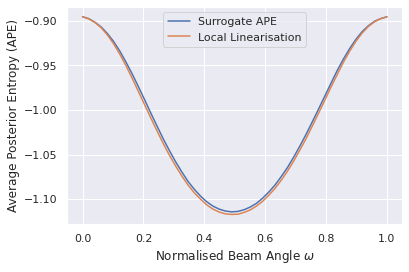

In [17]:
d_vals = jnp.linspace(0,1,50)
with open(os.path.join(data_save_dir, 'linearbeam_ape.json'), 'r') as f:
    ape_vals = json.load(f)

fig, ax = plt.subplots()
for i, (key, ape_i) in enumerate(ape_vals.items()):
    sns.lineplot(x=np.array(d_vals).squeeze(), y=np.array(ape_i).squeeze(), color=palette[i], label=key)
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Average Posterior Entropy (APE)')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'ape_comparison.svg'))

# Effect of Noise

In [18]:
prior_cov = 0.01*jnp.identity(1)
prior_mean = 0.5*jnp.ones((1,))
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
num_samples = 1000
noise_cov_list = jnp.linspace(0.001, 0.01, 10)
d_vals = jnp.linspace(0,1,50)
ape_noise = []
for i, noise_cov in enumerate(noise_cov_list):
    print(f'Computing APE loss landscape for noise_cov = {noise_cov} ({i+1}/{len(noise_cov_list)})')
    likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
    laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, 
                                                                               noise_cov, prior_mean, prior_cov)
    laplace_ape = oed_toolbox.losses.APE(prior, likelihood, laplace_approx, use_reparameterisation=True)
    ape_vals = []
    for i, d in enumerate(d_vals):
        ape_vals.append(laplace_ape(d, num_samples=num_samples, rng=np.random.default_rng(np_seed), return_grad=False))
    ape_noise.append(ape_vals)

noise_experiment = {'noise_cov': noise_cov_list, 'd': d_vals, 'ape': ape_noise}

with open(os.path.join(data_save_dir, 'ape_noise_linearbeam.json'), 'w') as f:
    json.dump(Arraytainer(noise_experiment).tolist(), f, indent=4)

Computing APE loss landscape for noise_cov = 0.0010000000474974513 (1/10)
Computing APE loss landscape for noise_cov = 0.0020000000949949026 (2/10)
Computing APE loss landscape for noise_cov = 0.003000000026077032 (3/10)
Computing APE loss landscape for noise_cov = 0.004000000189989805 (4/10)
Computing APE loss landscape for noise_cov = 0.005000000353902578 (5/10)
Computing APE loss landscape for noise_cov = 0.006000000052154064 (6/10)
Computing APE loss landscape for noise_cov = 0.007000000216066837 (7/10)
Computing APE loss landscape for noise_cov = 0.00800000037997961 (8/10)
Computing APE loss landscape for noise_cov = 0.009000000543892384 (9/10)
Computing APE loss landscape for noise_cov = 0.009999999776482582 (10/10)


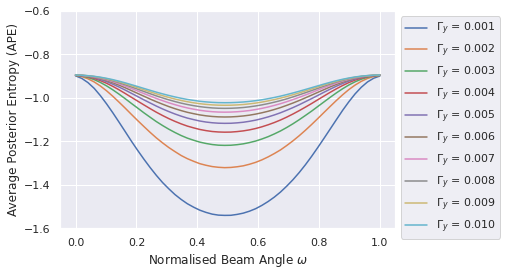

In [19]:
with open(os.path.join(data_save_dir, 'ape_noise_linearbeam.json'), 'r') as f:
    noise_experiment = json.load(f)

fig, ax = plt.subplots()
for i, (noise_cov, ape_i) in enumerate(zip(noise_experiment['noise_cov'], noise_experiment['ape'])):
    sns.lineplot(x=np.array(noise_experiment['d']).squeeze(), y=np.array(ape_i).squeeze(), 
                 color=palette[i], label=f'$\Gamma_y$ = {noise_cov:.3f}')
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Average Posterior Entropy (APE)')
ax.set_ylim(*ape_ylims)
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'noise_effect_linearbeam.svg'), bbox_inches='tight')
plt.show()

# Effect of Prior

In [20]:
prior_cov_list= jnp.linspace(0.005, 0.015, 10)
prior_mean_list = jnp.linspace(0.3, 0.7, 10)
prior_combos = list(itertools.product(prior_mean_list, prior_cov_list))

In [21]:
noise_cov = 0.005
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
num_samples = 1000
d_vals = jnp.linspace(0,1,50)
minimizer = oed_toolbox.optim.gradient_descent_for_map(lr=1e-4)
ape_prior, prior_means, prior_covs = [], [], []
for i, (prior_mean, prior_cov) in enumerate(prior_combos):
    print(f'Computing APE loss landscape for prior {i+1}/{len(prior_combos)} (mean = {prior_mean:.2f}, cov = {prior_cov:.4f})')
    prior_means.append(prior_mean)
    prior_covs.append(prior_cov)
    prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
    laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, 
                                                                               noise_cov, prior_mean, prior_cov)
    laplace_ape = oed_toolbox.losses.APE(prior, likelihood, laplace_approx, use_reparameterisation=True)
    ape_vals = []
    for i, d in enumerate(d_vals):
        ape_vals.append(laplace_ape(d, num_samples=num_samples, rng=np.random.default_rng(np_seed), return_grad=False))
    ape_prior.append(ape_vals)

prior_experiment = {'mean': prior_means, 'cov': prior_covs, 'ape': ape_prior, 'd': d_vals}

with open(os.path.join(data_save_dir, 'ape_prior_linearbeam.json'), 'w') as f:
    json.dump(Arraytainer(prior_experiment).tolist(), f, indent=4)

Computing APE loss landscape for prior 1/100 (mean = 0.30, cov = 0.0050)
Computing APE loss landscape for prior 2/100 (mean = 0.30, cov = 0.0061)
Computing APE loss landscape for prior 3/100 (mean = 0.30, cov = 0.0072)
Computing APE loss landscape for prior 4/100 (mean = 0.30, cov = 0.0083)
Computing APE loss landscape for prior 5/100 (mean = 0.30, cov = 0.0094)
Computing APE loss landscape for prior 6/100 (mean = 0.30, cov = 0.0106)
Computing APE loss landscape for prior 7/100 (mean = 0.30, cov = 0.0117)
Computing APE loss landscape for prior 8/100 (mean = 0.30, cov = 0.0128)
Computing APE loss landscape for prior 9/100 (mean = 0.30, cov = 0.0139)
Computing APE loss landscape for prior 10/100 (mean = 0.30, cov = 0.0150)
Computing APE loss landscape for prior 11/100 (mean = 0.34, cov = 0.0050)
Computing APE loss landscape for prior 12/100 (mean = 0.34, cov = 0.0061)
Computing APE loss landscape for prior 13/100 (mean = 0.34, cov = 0.0072)
Computing APE loss landscape for prior 14/100 (

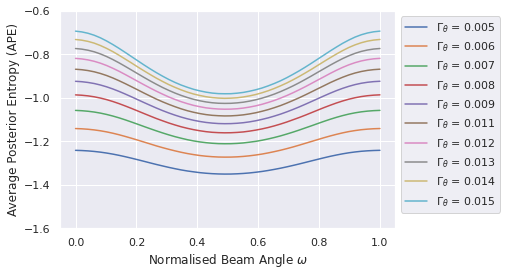

In [22]:
with open(os.path.join(data_save_dir, 'ape_prior_linearbeam.json'), 'r') as f:
    prior_experiment = json.load(f)

mean_idx_to_plot = 5
plot_freq = 1
fig, ax = plt.subplots()
num_plotted = num_found = 0
mean_to_plot = np.unique(prior_experiment['mean'])[mean_idx_to_plot]
for i, mean in enumerate(prior_experiment['mean']):
    if np.isclose(mean, mean_to_plot):
        if num_found % plot_freq == 0:
            ape_i = np.array(prior_experiment['ape'])[i,:]
            prior_cov = prior_experiment['cov'][i]
            sns.lineplot(x=np.array(prior_experiment['d']).squeeze(), y=ape_i.squeeze(), 
                         color=palette[num_plotted], label=f'$\Gamma_\\theta$ = {prior_cov:.3f}')
            num_plotted += 1
        num_found += 1
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Average Posterior Entropy (APE)')
plt.legend(bbox_to_anchor=(1,1))
ax.set_ylim(*ape_ylims)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'prior_cov_linear_beam.svg'), bbox_inches='tight')

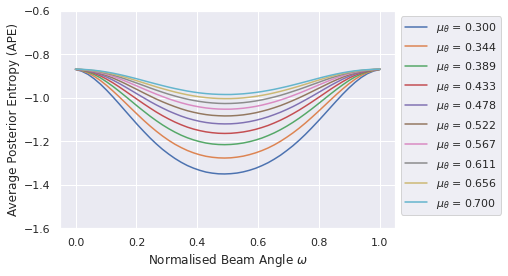

In [23]:
with open(os.path.join(data_save_dir, 'ape_prior_linearbeam.json'), 'r') as f:
    prior_experiment = json.load(f)

cov_idx_to_plot = 5
plot_freq = 1
fig, ax = plt.subplots()
num_plotted = num_found = 0
cov_to_plot = np.unique(prior_experiment['cov'])[cov_idx_to_plot]
for i, cov in enumerate(prior_experiment['cov']):
    if np.isclose(cov, cov_to_plot):
        if num_found % plot_freq == 0:
            ape_i = np.array(prior_experiment['ape'])[i,:]
            prior_mean = prior_experiment['mean'][i]
            sns.lineplot(x=np.array(prior_experiment['d']).squeeze(), y=ape_i.squeeze(), 
                         color=palette[num_plotted], label=f'$\mu_\\theta$ = {prior_mean:.3f}')
            num_plotted+=1
        num_found += 1
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Average Posterior Entropy (APE)')
plt.legend(bbox_to_anchor=(1,1))
ax.set_ylim(*ape_ylims)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'prior_mean_linear_beam.svg'), bbox_inches='tight')

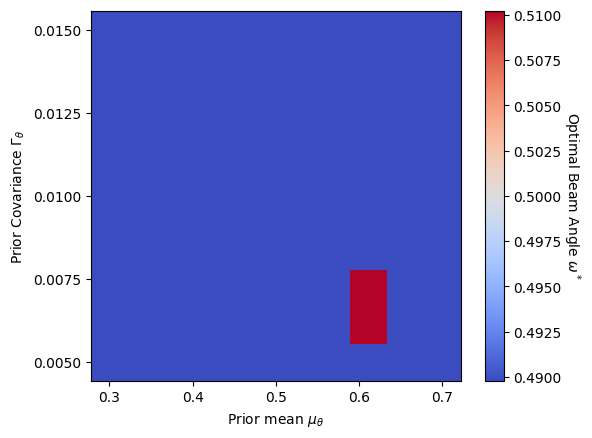

In [24]:
with open(os.path.join(data_save_dir, 'ape_prior_linearbeam.json'), 'r') as f:
    prior_experiment = json.load(f)

grid_len = 10
oed_list = []
d_vals = prior_experiment['d']
for ape_i in prior_experiment['ape']:
    smallest_ape_idx = np.argsort(ape_i)[0]
    oed_list.append(d_vals[smallest_ape_idx])
oed = np.array(oed_list).reshape(grid_len,grid_len,order='F')
x_grid = np.array(prior_experiment['mean']).reshape(grid_len, grid_len)
y_grid = np.array(prior_experiment['cov']).reshape(grid_len,grid_len)
plt.rcdefaults()
fig, ax = plt.subplots()
im = plt.imshow(oed, cmap='coolwarm', origin='lower')
cbar = plt.colorbar(im)
cbar.set_label('Optimal Beam Angle $\omega^*$', rotation=270, labelpad=15)
plotting_helpers.set_x_and_y_ticks(ax, x_grid, y_grid, num_x_ticks=5, num_y_ticks=5, x_dp=1, y_dp=4)
ax.set_xlabel('Prior mean $\mu_\\theta$')
ax.set_ylabel('Prior Covariance $\Gamma_\\theta$')
sns.set_theme(style='darkgrid')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'prior_effect_surface.svg'))